# <font color='orange'>**Introduction to Audio Classification with Machine Learning and Deep Neural Networks**</font>

<font color='Blue'>**Abstract-**</font>
In this project we have figure out the sentiment category from audio tone — either calm, happy, sad, angry, fearful, surprise, and disgust — they fall under.I focus particularly on feature engineering techniques for audio data and provide an in-depth look at the logic, concepts, and properties of the deep neural networks (DNNs) today. I also provide an introduction to a few key machine learning models and the logic in choosing their hyperparameters.

<font color='Green'>**Installing Dependencies**</font>

In [ ]:
!pip install pydub
!pip install noisereduce
!pip install json-tricks
!pip install ffmpeg-python
!pip install sounddevice
!sudo apt-get install libportaudio2
!pip install sounddevice
! [ -e /content ] && pip install -Uqq fastai 
!pip3 install git+https://github.com/fastai/fastai.git

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following packages were automatically installed and are no longer required:
  libnvidia-common-460 nsight-compute-2020.2.0
Use 'sudo apt autoremove' to remove them.
The following NEW packages will be installed:
  libportaudio2
0 upgraded, 1 newly installed, 0 to remove and 42 not upgraded.
Need to get 64.6 kB of archives.
After this operation, 215 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libportaudio2 amd64 19.6.0-1 [64.6 kB]
Fetched 64.6 kB in 0s (183 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: fallin

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# <font color='Green'>**Table of Contents**</font>
1.   Intro: Speech Emotion Recognition on the RAVDESS dataset
2.   Feature Extraction
    *   Load the Dataset and Compute Features
    *   Feature Scaling
3.   Feature Engineering
    *   Mel-Frequency Cepstral Coefficients
    *   Mel Spectrograms and Mel-Frequency Cepstrums
    *   The Chromagram
4.   Classical Machine Learning Models with Accuracy( Precision, Recall, F-Score )
    *   Training: The 70/30 Split and Validation
    *   k Nearest Neighbours
    *   Random Forests Classifier
    *   XGB Classifier
5.   Feature extraction 
    *   Graphical spectrogram for all data
    *   Visulize image representations of the audio
6.   Training and Evaluating the Deep Neural network(DNN) Model 
    *   CNN Model
        *   The Confusion Matrix, Precision, Recall, F-Score 
        *   The loss function 
    *   Resnet model with live audio speech
        *   The Confusion Matrix, Precision, Recall, F-Score 
        *   The Learning Curve: Determining Optimal Training Set Size




<font color='Green'>Importing Necessary Libraries


*   Librosa: Python package for music and audio analysis.
*   Scipy.io.wavfile: Return the sample rate (in samples/sec) and data from a 
    WAV file.
*   Glob: Used to return all file paths that match a specific pattern.
*   Fastai: Fastai is a deep learning library that provides practitioners with high-level components that can quickly and easily provide state-of-the-art results in standard deep learning domains



*    Struct: Used to unpack audio data into integers
*    Tkinter: Tkinter is the standard GUI library for Python. Python when combined with Tkinter provides a fast and easy way to create GUI applications.
*    Sounddevice: This Python module provides bindings for the PortAudio library and a few convenient functions to play and record NumPy arrays containing audio signals.



In [ ]:
import numpy as np
from pydub import AudioSegment, effects
import librosa,os
import plotly.graph_objects as go
import plotly.express as graph
import librosa.display
import noisereduce as nr
import soundfile

import IPython
from IPython.display import HTML, Audio
from google.colab.output import eval_js
import tensorflow as tf
import keras,sklearn,glob,io,scipy
from scipy.io.wavfile import write
from scipy.io.wavfile import read as wav_read
from base64 import b64decode
import ffmpeg,sounddevice
from matplotlib.colors import Normalize
from IPython.display import HTML, Audio
from google.colab.output import eval_js
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras import layers,optimizers,callbacks

In [ ]:
# matplotlib complains about the behaviour of librosa.display, so we'll ignore those warnings:
import warnings; warnings.filterwarnings('ignore')
from IPython.core.display import HTML 
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split,GridSearchCV
from matplotlib.colors import Normalize
from sklearn.neighbors import KNeighborsClassifier

import xgboost as xgb
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

In [ ]:
from fastai import *                                 
from fastai.vision.all import *
from fastai.vision.data import ImageDataLoaders
from fastai.tabular.all import *
from fastai.text.all import *
from fastai.vision.widgets import *
import torch
torch.cuda.empty_cache()

import struct
import time
from tkinter import TclError
from scipy.fftpack import fft

<font color='Green'>Helper Functions

We're going to use the audio-only speech portion of the RAVDESS dataset, ~200MB. Audio is sourced from 24 actors (12 male, 12 female) repeating two sentences with a variety of emotions and intensity. We get 1440 speech files (24 actors * 60 recordings per actor). Each audio sample has been rated by a human 10 times for emotional quality.
<br>
for our Dataset we had considered '1’:neutral, '2’:calm, '3’:happy, '4’:sad, '5’:angry, '6’:fearful, '7’:disgust
and ’08’:surprised

In [ ]:
emotions ={
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fearful',
  '07':'disgust',
  '08':'surprised'
}

audio_path = '/content/drive/MyDrive/Prml_project/speech_emotion_recognition/*'

In [ ]:
def get_emotion(audio_folder):
  emo = []
  count = 0
  for actor in glob.glob(audio_folder):       
        for audioFile in glob.glob(actor +'/*'):  
           emotion=emotions[str(audioFile[-18:-16])]
           if emotion == 'neutral':
             b = 0
           elif emotion == 'calm':
             b = 1
           elif emotion == 'happy':
             b = 2
           elif emotion == 'sad':
             b = 3
           elif emotion == 'angry':
             b = 4
           elif emotion == 'fearful':
             b = 5
           elif emotion == 'disgust':
             b = 6
           else:
             b = 7
           emo.append(b)
           count += 1
        print('\r' + f' Processed {count}/{1440} audio samples',end=' ')
  return np.array(emo)

In [ ]:
def visualize_confusion_matrix(true,predicted,colour='BuGn'):

  y_arg_val = np.argmax(true,axis=1)
  y_argpred_class = np.argmax(predicted, axis=1)
  cm=confusion_matrix(y_arg_val, y_argpred_class)

  index = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']  
  columns = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']  

  cm_df = pd.DataFrame(cm,index,columns)                      
  plt.figure(figsize=(10,6))
  ax = plt.axes()

  sns.heatmap(cm_df, ax = ax, cmap = colour, fmt="d", annot=True)
  ax.set_ylabel('True emotion')
  ax.set_xlabel('Predicted emotion')

  return cm

# <font color="Green">Data Visualization<font>

Here is visualization for dataset, the classes appears to be balanced. That makes the task easier. All emotions
except the neutral class have a ”strong” intensity so there are half as many neutral samples.


In [ ]:
labels =  [i for i in emotions.values()]
sent = get_emotion(audio_path)
emotion_list, count = np.unique(sent, return_counts=True)
values = count
fig = go.Figure(data=[go.Pie(labels=labels, values=values)])
fig.update_layout(title = "Pie graph for types of Emotions in the data",
                  autosize=False,width=500,height=500)
fig.show()

 Processed 1440/1440 audio samples 

An Audio file of Happy and Angry class represented as a time series with
the dependent axis being the amplitude of the audio waveform.

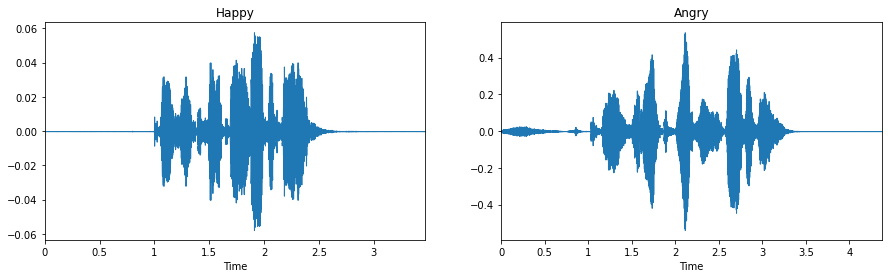

In [ ]:
with soundfile.SoundFile('/content/drive/MyDrive/Prml_project/speech_emotion_recognition/Actor_01/03-01-03-01-01-01-01.wav') as audio:
    happy_waveform = audio.read(dtype="float32")
    sample_rate = audio.samplerate
    plt.figure(figsize=(15,4))
    plt.subplot(1, 2, 1)
    librosa.display.waveplot(happy_waveform, sr=sample_rate)
    plt.title('Happy')

with soundfile.SoundFile('/content/drive/MyDrive/Prml_project/speech_emotion_recognition/Actor_01/03-01-05-02-01-02-01.wav') as audio:
    angry_waveform = audio.read(dtype="float32")
    sample_rate = audio.samplerate
    plt.subplot(1, 2, 2)
    librosa.display.waveplot(angry_waveform, sr=sample_rate)
    plt.title('Angry')

<font color="Green">**Visualize the combination of power spectrograms output by STFT w.r.t time:-**<font>
*    We operate under the assumption that features whose interclass differences we can visualize will be good candidates on which to train a neural network.


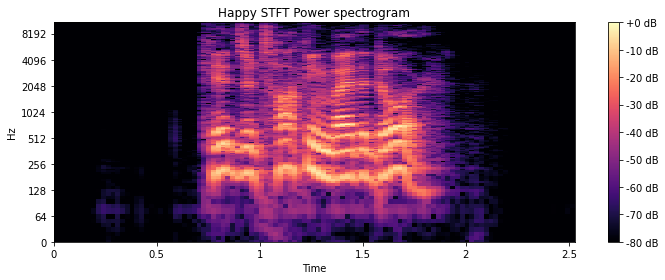

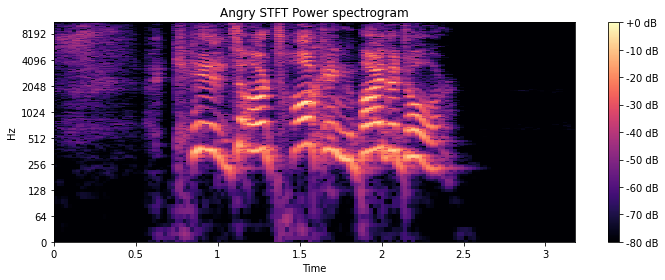

In [ ]:
stft_spectrum_matrix = librosa.stft(happy_waveform)
plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.amplitude_to_db(np.abs(stft_spectrum_matrix), ref=np.max),y_axis='log', x_axis='time')
plt.title('Happy STFT Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()

stft_spectrum_matrix = librosa.stft(angry_waveform)
plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.amplitude_to_db(np.abs(stft_spectrum_matrix), ref=np.max),y_axis='log', x_axis='time')
plt.title('Angry STFT Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()

<font color="Green">**Mel-Frequency Cepstral Coefficients:-**<font>
*    MFCC is a mathematical method which transforms the power spectrum of an audio signal to a small number of coefficients representing power of the audio signal in a frequency region (a region of pitch) taken w.r.t. time.

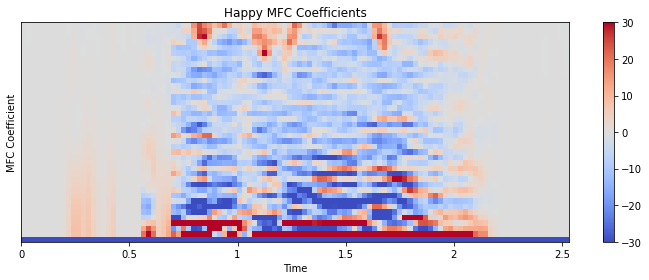

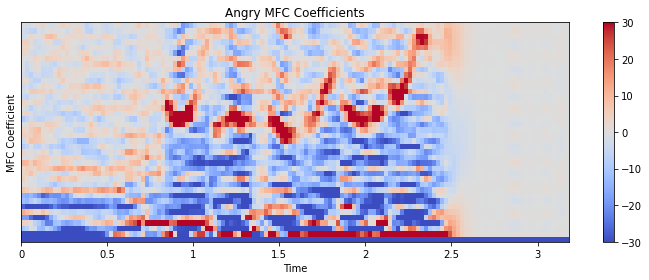

In [ ]:
from matplotlib.colors import Normalize
mfc_coefficients = librosa.feature.mfcc(y=happy_waveform, sr=sample_rate, n_mfcc=40)
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfc_coefficients, x_axis='time',norm=Normalize(vmin=-30,vmax=30))
plt.colorbar()
plt.yticks(())
plt.ylabel('MFC Coefficient')
plt.title('Happy MFC Coefficients')
plt.tight_layout()
                                        
mfc_coefficients = librosa.feature.mfcc(y=angry_waveform, sr=sample_rate, n_mfcc=40)
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfc_coefficients, x_axis='time',norm=Normalize(vmin=-30,vmax=30))
plt.colorbar()
plt.yticks(())
plt.ylabel('MFC Coefficient')
plt.title('Angry MFC Coefficients')
plt.tight_layout()

<font color="Green">**Mel Spectrograms:-**<font>
*    We build a chromagram on each power spectrogram computed by STFT. A chromagram is a representation of an audio signal w.r.t. time, mapping audio signal to a pitch class.

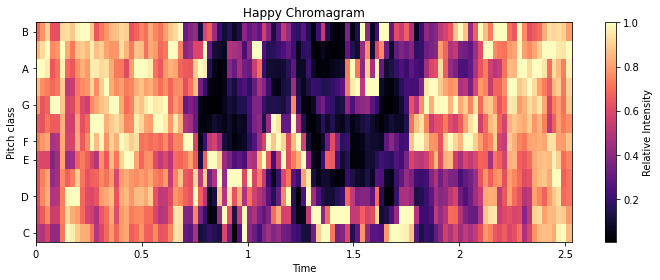

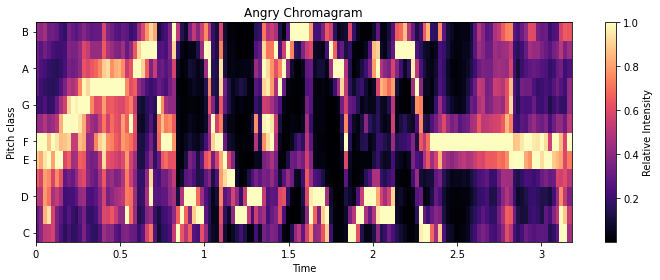

In [ ]:
chromagram = librosa.feature.chroma_stft(y=happy_waveform, sr=sample_rate)
plt.figure(figsize=(10, 4))
librosa.display.specshow(chromagram, y_axis='chroma', x_axis='time')
plt.colorbar(label='Relative Intensity')
plt.title('Happy Chromagram')
plt.tight_layout()

chromagram = librosa.feature.chroma_stft(y=angry_waveform, sr=sample_rate)
plt.figure(figsize=(10, 4))
librosa.display.specshow(chromagram, y_axis='chroma', x_axis='time')
plt.colorbar(label='Relative Intensity')
plt.title('Angry Chromagram')
plt.tight_layout()

# <font color="Green">Feature Extraction for Machine Learning Models</font>

We had used librosa, a Python library enabling audio analysis and feature extraction. Librosa abstracts away all the math and most of the details of mel spectrorgams, chromagrams, and MFCC. Although closely related, we're going to take the Mel Spectrogram, MFCC, and chromagrams of each audio file as separate features to try and have bit more discriminatory power

we're going to get a matrix back from each function(chromagram, a mel spectorgram, and MFC coefficients), so we'll take the mean of those matrices to produce a single feature array for each feature and each audio sample, i.e. 3 feature arrays per audio sample

In [ ]:
def get_features(file):
     with soundfile.SoundFile(file) as audio:
        waveform = audio.read(dtype="float32")
        sample_rate = audio.samplerate

        # STFT computed here explicitly; mel spectrogram and MFCC functions do this under the hood
        stft_spectrogram=np.abs(librosa.stft(waveform))

        # Produce the chromagram for all STFT frames and get the mean of each column of the resulting matrix to create a feature array
        chromagram=np.mean(librosa.feature.chroma_stft(S=stft_spectrogram, sr=sample_rate).T,axis=0)
        
        # Produce the mel spectrogram for all STFT frames and get the mean of each column of the resulting matrix to create a feature array
        # Using 8khz as upper frequency bound should be enough for most speech classification tasks
        melspectrogram=np.mean(librosa.feature.melspectrogram(y=waveform, sr=sample_rate, n_mels=128, fmax=8000).T,axis=0)
 
        # Compute the MFCCs for all STFT frames and get the mean of each column of the resulting matrix to create a feature array
        # 40 filterbanks = 40 coefficients
        mfc_coefficients=np.mean(librosa.feature.mfcc(y=waveform, sr=sample_rate, n_mfcc=40).T, axis=0) 

        feature_matrix = np.hstack((chromagram, melspectrogram, mfc_coefficients))
        return feature_matrix

<font color="Green">Finally, loaded our entire dataset and compute the features of each audio file</font><br>
Compute the feature matrix and read the emotion labels for the entire dataset. 

In [ ]:
def load_data(audio_folder):
  X = []
  count = 0
  for actor in glob.glob(audio_folder):       
        for audioFile in glob.glob(actor +'/*'):  
           features = get_features(audioFile)
           X.append(features)
           count += 1
        print('\r' + f' Processed {count}/{1440} audio samples',end=' ')
  y = get_emotion(audio_folder)
  return np.array(X), y

In [ ]:
features, sentiment = load_data(audio_path)

 Processed 1440/1440 audio samples 

In [ ]:
features_df = pd.DataFrame(features) # make it pretty for display
features_df.head()

,0,1,2,3,4,5,6,7,8,9,...,170,171,172,173,174,175,176,177,178,179
0,0.617114,0.590792,0.619092,0.624207,0.626070,0.613644,0.672888,0.688502,0.706097,0.781341,...,1.931213,1.651866,1.224706,-1.383795,-0.017351,0.142802,2.259798,0.792838,-1.074773,0.181455
1,0.581366,0.631825,0.621572,0.615981,0.674658,0.714151,0.757309,0.716134,0.687570,0.713317,...,0.172788,1.605608,0.261927,0.651645,-0.385674,0.059573,1.603198,0.175985,-0.566163,-1.454906
2,0.629294,0.637800,0.679903,0.646860,0.614826,0.676928,0.691453,0.668414,0.744655,0.751017,...,1.601328,-0.169668,1.185772,-2.276853,-2.760550,-1.581679,1.258095,-0.160674,-0.765662,-2.052895
3,0.555138,0.564285,0.647232,0.633285,0.607550,0.675437,0.715801,0.724736,0.815370,0.779961,...,1.283730,0.292617,0.869254,-1.206635,-2.267522,-0.938547,0.519972,-0.786948,-0.854646,-1.616559
4,0.547652,0.587740,0.628562,0.611418,0.680220,0.720484,0.712949,0.649248,0.687055,0.811569,...,0.833452,0.676934,-0.159737,-2.042957,0.443028,1.355047,0.823759,-0.280882,-1.397293,-1.201413


<font color="Green">Feature Scaling - </font>
We did standard scaling which is more practical for features with unknown distributions because centering the features at zero-mean with a standard deviation of 1 means extreme values will have less of an impact on the model's learned weights, i.e. the model is less sensitive to outliers.

Our regressor (independent/explanatory variable), usually denoted X, is named 'features', and our regressand (dependent variable), usually denoted y, is named 'emotions'.

In [ ]:
scale = StandardScaler()
features_scaled = scale.fit_transform(features_df)

#Standard Scaled test/train set
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(
    features_scaled, 
    sentiment, 
    test_size=0.2, 
    random_state=69
)

train and text set splitted in [70:30]

In [ ]:
x_train1, x_tosplit, y_train1, y_tosplit = train_test_split(X_train_scaled, y_train, test_size = 0.30, random_state = 1)

In [ ]:
# Split to train, validation, and test sets.
x_train, x_tosplit, y_train_1, y_tosplit = train_test_split(X_train_scaled, y_train, test_size = 0.30, random_state = 1)
x_val, x_test, y_val, y_test = train_test_split(x_tosplit, y_tosplit, test_size = 0.10, random_state = 1)

#'One-hot' vectors for Y: emotion classification
y_train_1 = tf.keras.utils.to_categorical(y_train_1, 8, dtype = 'int8')
y_val_class = tf.keras.utils.to_categorical(y_val, 8, dtype = 'int8')
y_test_class = tf.keras.utils.to_categorical(y_test, 8, dtype = 'int8')

#  <font color="Green">Machine Learning Models training and Evaluation

 <font color="Blue">K Nearest Neighbor -</font> KNN is one of the simplest forms of machine learning algorithms mostly used for
classification. KNN classifies the new data points based on the similarity measure of the earlier stored data
points. We have taken k = 8 and got accuracy of 47.099% over testing.


In [ ]:
# Hyperparameter tuning for KNN using GridSearchCv
leaf_size = list(range(1,50))
n_neighbors = list(range(1,30))
p=[1,2]

hyperparameters = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p)
knn_2 = KNeighborsClassifier()
clf = GridSearchCV(knn_2, hyperparameters, cv=5)
best_model = clf.fit(x_train1, y_train1)
print('Best leaf_size:', best_model.best_estimator_.get_params()['leaf_size'])
print('Best p:', best_model.best_estimator_.get_params()['p'])
print('Best n_neighbors:', best_model.best_estimator_.get_params()['n_neighbors'])

Best leaf_size: 1
Best p: 1
Best n_neighbors: 1


<font color="Blue"> Classification report for KNN ( Precision, Recall, F-Score )

In [ ]:
model1 = KNeighborsClassifier(n_neighbors = 1,p=1,leaf_size=1)
model1.fit(x_train1, y_train1)
pred1 = model1.predict(x_tosplit)
acc1 = round(accuracy_score(y_tosplit,pred1),3)
print("Accuracy score of KNeighborsClassifier: ",acc1*100,"%\n")
print("Classification Report: \n")
print(classification_report(y_tosplit, pred1, target_names=emotions.values()))

Accuracy score of KNeighborsClassifier:  61.3 %

Classification Report: 

              precision    recall  f1-score   support

     neutral       0.44      0.52      0.47        27
        calm       0.81      0.79      0.80        58
       happy       0.46      0.40      0.43        48
         sad       0.55      0.54      0.54        41
       angry       0.73      0.65      0.69        46
     fearful       0.62      0.66      0.64        35
     disgust       0.59      0.66      0.62        50
   surprised       0.60      0.61      0.60        41

    accuracy                           0.61       346
   macro avg       0.60      0.60      0.60       346
weighted avg       0.61      0.61      0.61       346



<font color="Blue">Random Forest Classifier -</font> Random forests algorithm is general technique of bootstrap aggregating to tree
learners. Given a training set X with responses Y, bagging repeatedly selects a random sample with replacement
of the training set and fits trees to these samples.Random forest was fitted with different parameters. We find
that the best accuracy of 54.0% was achieved.


<font color="Blue"> Classification report for RFC ( Precision, Recall, F-Score )

In [ ]:
model2 = RandomForestClassifier(max_depth=110,min_samples_leaf=1,
                            min_samples_split=8,n_estimators=300)
model2.fit(x_train1, y_train1)
pred2 = model2.predict(x_tosplit)
acc2 = round(accuracy_score(y_tosplit,pred2),3)
print("Accuracy score of Random Forest Classifier: ",acc2*100,"%\n")
print("Classification Report: \n")
print(classification_report(y_tosplit, pred2, target_names=emotions.values()))

Accuracy score of Random Forest Classifier:  54.0 %

Classification Report: 

              precision    recall  f1-score   support

     neutral       0.55      0.22      0.32        27
        calm       0.59      0.88      0.70        58
       happy       0.50      0.21      0.29        48
         sad       0.50      0.37      0.42        41
       angry       0.76      0.61      0.67        46
     fearful       0.42      0.51      0.46        35
     disgust       0.51      0.62      0.56        50
   surprised       0.49      0.68      0.57        41

    accuracy                           0.54       346
   macro avg       0.54      0.51      0.50       346
weighted avg       0.54      0.54      0.52       346



<font color="Blue">XGB Classifier -</font> XGBoost, which stands for Extreme Gradient Boosting is an implementation of Gradient
Boosted decision trees. In it decision trees are created in sequential form. Weights are assigned to all the inde-
pendent variables which are then fed into the decision tree which predicts results. These individual classifiers
then ensemble to give a more precise model. We achieved an accuracy of 53.5% over testing

<font color="Blue"> Classification report for XGB ( Precision, Recall, F-Score )

In [ ]:
model3 = xgb.XGBClassifier()
model3.fit(x_train1, y_train1)
pred3 = model3.predict(x_tosplit)
acc3 = round(accuracy_score(y_tosplit,pred3),3)
print("Accuracy score of XGBoost Classifier: ",acc3*100,"%\n")
print("Classification Report: \n")
print(classification_report(y_tosplit, pred3, target_names=emotions.values()))

Accuracy score of XGBoost Classifier:  53.5 %

Classification Report: 

              precision    recall  f1-score   support

     neutral       0.67      0.30      0.41        27
        calm       0.60      0.74      0.66        58
       happy       0.65      0.46      0.54        48
         sad       0.31      0.34      0.33        41
       angry       0.67      0.57      0.61        46
     fearful       0.42      0.54      0.48        35
     disgust       0.57      0.56      0.57        50
   surprised       0.48      0.59      0.53        41

    accuracy                           0.53       346
   macro avg       0.55      0.51      0.51       346
weighted avg       0.55      0.53      0.53       346



# <font color="Orange"> Model's based on Deep Neural Network

1.   CNN Model
2.   Resnet Model



# <font color="Green"> Convolutional Neural Network Model Definition & Train

A four hidden layers Neural Network was trained. The first layer was
accompanied by BatchNormalization and a Dropout rate of 0.7. Batch normalization applies a transformation
that maintains the mean output close to 0 and the output standard deviation close to 1.

In [ ]:
# Initializing the model

model = Sequential()
model.add(keras.layers.Dense(64,input_shape = (180,),activation='relu'))
model.add(keras.layers.Dense(64,input_shape = (180,),activation='sigmoid'))
model.add(keras.layers.Dropout(0.07))
model.add(keras.layers.Dense(8, activation = 'softmax'))
print(model.summary())

batch_size = 23

# Callbacks functions
checkpoint_path = '/content/drive/My Drive/Colab Notebooks/best_weights.hdf5'

#-> Save the best weights
mcp_save = callbacks.ModelCheckpoint(checkpoint_path, save_best_only=True,
                           monitor='val_categorical_accuracy',
                           mode='max')

                             
# Compile & train   
model.compile(loss='categorical_crossentropy', 
                optimizer='RMSProp', 
                metrics=['categorical_accuracy'])

history = model.fit(x_train, y_train_1, 
                      epochs=100, batch_size = batch_size, 
                      validation_data = (x_val, y_val_class), 
                      callbacks = [mcp_save])
# Define the best weights to the model.
pickle.dump(model, open('model.pkl', 'wb'))
model.load_weights(checkpoint_path)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                11584     
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 8)                 520       
                                                                 
Total params: 16,264
Trainable params: 16,264
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
36/36 [==============================] - 1s 16ms/step - loss: 2.0355 - categorical_accuracy: 0.1960 - val_loss: 1.9089 - val_categorical_accuracy: 0.3215
Epoch 2/100
3

<font color="Green">Activation
function for all three layers was Relu except the last hidden layer which utilized Sigmoid
activation function. It achieved a validation accuracy of 84.91 However, the testing accuracy was 63.7

<font color="Blue">Loss Function Plot - </font>

*   We have plotted the Loss function plot for loss and val_loss on training and validation data.
*   We have plotted the Accuracy plot for categorical_accuracy and       val_categorical_accuracy on training and validation data.

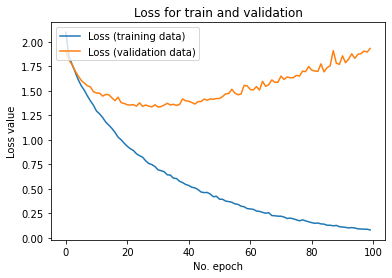

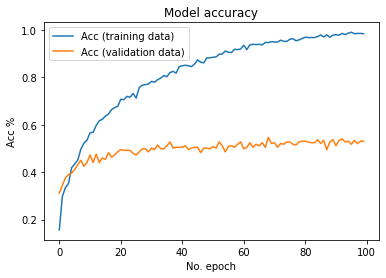

In [ ]:
# Plot history: Loss
plt.plot(history.history['loss'], label='Loss (training data)')
plt.plot(history.history['val_loss'], label='Loss (validation data)')
plt.title('Loss for train and validation')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

#Plot history: Accuracy
plt.plot(history.history['categorical_accuracy'], label='Acc (training data)')
plt.plot(history.history['val_categorical_accuracy'], label='Acc (validation data)')
plt.title('Model accuracy')
plt.ylabel('Acc %')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()


*   We can see in loss plot the validation plot is upper than training Plot
*   We can see in loss plot the validation plot is lower than training Plot



# <font color="Orange">CNN Model Evaluation

<font color="Blue">CNN Model Structure Visulization

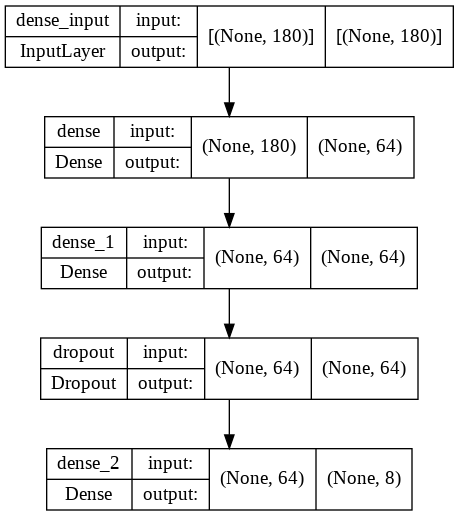

In [ ]:
# Model's structure visualization
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

Evaluation on Validation Dataset

In [ ]:
loss,acc = model.evaluate(x_val, y_val_class, verbose=2)

10/10 - 0s - loss: 1.5877 - categorical_accuracy: 0.5466 - 47ms/epoch - 5ms/step


<font color="Blue">Confusion matrix</font> is a table that is often used to describe the performance of a classification model (or "classifier") on a set of test data for which the true values are known.

<font color="Blue">Confusion matrix of validation set

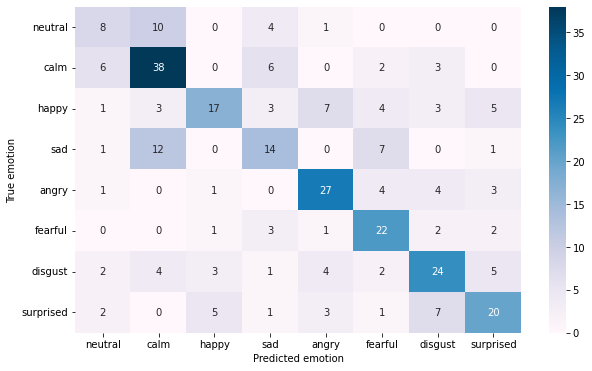

In [ ]:
predictions = model.predict(x_val)
cm = visualize_confusion_matrix(y_val_class,predictions,'PuBu')

<font color="Blue">Class wise accuracy of all emotions on validation set

In [ ]:
# Validation set prediction accuracy rates
b = [i for i in emotions.values()]
values = cm.diagonal()
row_sum = np.sum(cm,axis=1)
acc = values / row_sum

print('Validation set predicted emotions accuracy:')
for e in range(0, len(values)):
    print(b[e],':', f"{(acc[e]):0.4f}")

Validation set predicted emotions accuracy:
neutral : 0.3478
calm : 0.6909
happy : 0.3953
sad : 0.4000
angry : 0.6750
fearful : 0.7097
disgust : 0.5333
surprised : 0.5128


<font color="Blue">Confusion matrix of Testing set

In [ ]:
loss, acc = model.evaluate(x_test, y_test_class, verbose=2)

2/2 - 0s - loss: 1.6447 - categorical_accuracy: 0.5143 - 24ms/epoch - 12ms/step


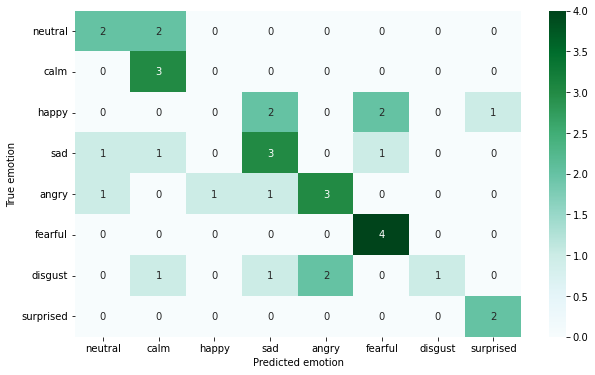

In [ ]:
predictions = model.predict(x_test)
cm = visualize_confusion_matrix(y_test_class,predictions,'BuGn')

<font color="Blue">Class wise accuracy of all emotions on Testing set

In [ ]:
# Test set prediction accuracy rates
values = cm.diagonal()
row_sum = np.sum(cm,axis=1)
acc = values / row_sum

print('Test set predicted emotions accuracy:')
for e in range(0, len(values)):
    print(b[e],':', f"{(acc[e]):0.4f}")

Test set predicted emotions accuracy:
neutral : 0.5000
calm : 1.0000
happy : 0.0000
sad : 0.5000
angry : 0.5000
fearful : 1.0000
disgust : 0.2000
surprised : 1.0000


# <font color="Green">Feature Extraction for Resnet Model</font>

<font color="Blue">Spectrogram with Audio files - </font>The first thing we will do is to convert the sound clips into a graphical spectrogram using the librosa library. That way they can be used to train the Resnet Model with live speech Emotion recognition.
<br>
We are converting the sound data into a spectrogram with the MEL scale as this scale. This scale is designed to make the image representations of the audio more interpretable

In [ ]:
folder_train = "/content/drive/MyDrive/Prml_project/output_folder_train/"
folder_test = "/content/drive/MyDrive/Prml_project/output_folder_test/"

The spectrograms will be placed into the directory system on computer categorized under a subdirectory with the name of the emotions — anger, disgust, fear, happiness, surprise, sadness, and neutral.

In [ ]:
counts = {}
for actor in glob.glob(audio_path):               # Loop through each actor in the data set 
  for audioFile in glob.glob(actor +'/*'):          # Loop over each audio file in that directory
    emotion=emotions[audioFile[-18:-16]]               # Returns numbers from the audio file name, 
                                                    # using the dictionary mapping each numerical value to emotions 
    save_path_train = folder_train + emotion        # Create new file name
    save_path_test = folder_test + emotion 

    y, sr = librosa.load(audioFile)                 # Load the file with librosa
    yt,_=librosa.effects.trim(y)                    # Trim leading and trailing silence from an audio signal.          
    y=yt
    # Creare spectrogram from audio file
    mel_spect = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=1024, hop_length=100)
    mel_spect = librosa.power_to_db(mel_spect, ref=np.max)
    librosa.display.specshow(mel_spect, y_axis='mel', fmax=20000, x_axis='time')
    
    # Create new file name
    count = counts.get(emotion, 1)
    print(count)
    if (count % 8 == 0):
      p = os.path.join(save_path_test, "{}{}.jpg".format(emotion, str(count).zfill(6)))
    else:
      p = os.path.join(save_path_train, "{}{}.jpg".format(emotion, str(count).zfill(6)))              
    counts[emotion] = count + 1
    # Save to the aforementioned path
    plt.savefig(p)
    print("Done!")
  print("Done actor!",actor)                                                         

# <font color="Green">Model Definition and Training

In [ ]:
train_path = Path("/content/drive/MyDrive/Prml_project/output_folder_train")
data = ImageDataLoaders.from_folder(train_path, valid_pct=0.2, seed=42, num_workers=0)
data.valid_ds.items[:10]

[Path('/content/drive/MyDrive/Prml_project/output_folder_train/surprised/surprised000020.jpg'),
 Path('/content/drive/MyDrive/Prml_project/output_folder_train/angry/angry000119.jpg'),
 Path('/content/drive/MyDrive/Prml_project/output_folder_train/sad/sad000050.jpg'),
 Path('/content/drive/MyDrive/Prml_project/output_folder_train/disgust/disgust000021.jpg'),
 Path('/content/drive/MyDrive/Prml_project/output_folder_train/disgust/disgust000115.jpg'),
 Path('/content/drive/MyDrive/Prml_project/output_folder_train/fearful/fearful000083.jpg'),
 Path('/content/drive/MyDrive/Prml_project/output_folder_train/sad/sad000043.jpg'),
 Path('/content/drive/MyDrive/Prml_project/output_folder_train/sad/sad000191.jpg'),
 Path('/content/drive/MyDrive/Prml_project/output_folder_train/fearful/fearful000161.jpg'),
 Path('/content/drive/MyDrive/Prml_project/output_folder_train/happy/happy000147.jpg')]

<font color="Blue">plotted Spectrogram for Every Class -

['angry', 'calm', 'disgust', 'fearful', 'happy', 'neutral', 'sad', 'surprised'] 



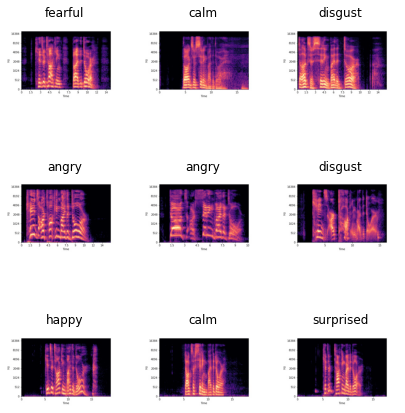

In [ ]:
print(data.vocab,'\n')
data.show_batch(figsize=(7,8))

# <font color="orange">Resnet model ("Deep Residual Learning for Image Recognition")</font>
Decodes the prediction of an ImageNet model. preprocess_input(...). Preprocesses a tensor or Numpy array encoding a batch of images.
ResNets are called Residual Networks. ResNet is a special type of Convolutional Neural Network (CNN) that is used for tasks like Image Recognition

<font color="orange">Model will be trained to identify and interpret patterns that correlate to emotion categories from spectrogram representations of audio.

<font color="Blue"> Learning Plot for loaded dataset of spectrogram -

Minimum/10: 4.79e-03, steepest point: 1.10e-02


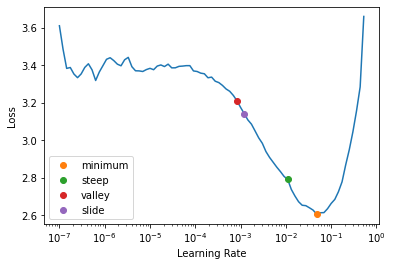

In [ ]:
model4 = vision_learner(data, models.resnet34, loss_func=CrossEntropyLossFlat(), metrics=accuracy)
lrs = model4.lr_find(suggest_funcs=(minimum, steep, valley, slide))
print(f"Minimum/10: {lrs.minimum:.2e}, steepest point: {lrs.steep:.2e}")

In [ ]:
print('model4.data.vocab', model4.dls.vocab)
print("\n")
model4.fit(40, float(f"{lrs.steep:.2e}"))

model4.data.vocab ['angry', 'calm', 'disgust', 'fearful', 'happy', 'neutral', 'sad', 'surprised']




epoch,train_loss,valid_loss,accuracy,time
0,2.863847,6.462590,0.100000,01:30
1,2.186793,1.933343,0.453846,00:29
2,1.749798,2.144367,0.442308,00:28
3,1.423682,1.700769,0.519231,00:28
4,1.187131,1.558641,0.515385,00:28
5,0.989360,2.651644,0.453846,00:28
6,0.852302,5.285198,0.303846,00:28
7,0.761377,2.788254,0.365385,00:28
8,0.695283,2.694262,0.450000,00:28
9,0.628390,2.958636,0.438462,00:28


# <font color="Green">Resnet Model Evaluation

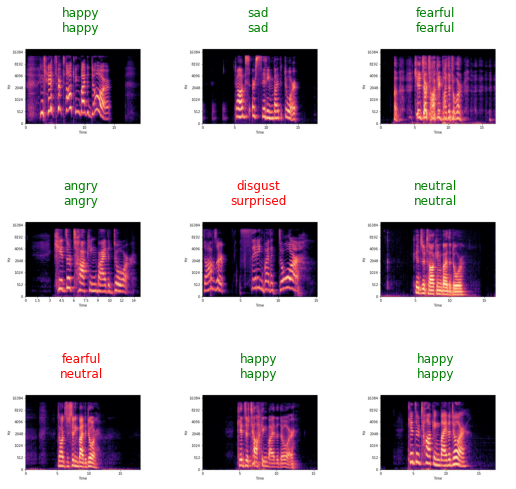

In [ ]:
model4.show_results()

<font color="Blue"> Classification Report for Resnet model

In [ ]:
interp = ClassificationInterpretation.from_learner(model4)
interp.print_classification_report()

              precision    recall  f1-score   support

       angry       0.63      0.61      0.62        31
        calm       1.00      0.03      0.06        35
     disgust       1.00      0.05      0.10        40
     fearful       1.00      0.03      0.06        34
       happy       0.53      0.65      0.59        37
     neutral       0.16      0.88      0.27        16
         sad       0.53      0.44      0.48        39
   surprised       0.44      0.96      0.60        28

    accuracy                           0.40       260
   macro avg       0.66      0.46      0.35       260
weighted avg       0.71      0.40      0.34       260



<font color="Blue"> Confusion Matrix for Resnet model

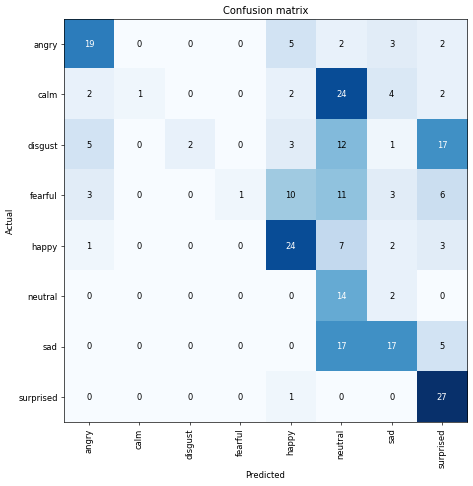

In [ ]:
interp.plot_confusion_matrix(figsize=(8,8), dpi=60)

<font color="Blue">Exported Resnet model as speech_model_1.pkl

In [ ]:
model4.freeze()
model4.export('speech_model_1.pkl')

# <font color="Green">Live Speech Emotion Recognition

<font color="Blue"> Loaded our model speech_model_1.pkl

In [ ]:
model = load_learner('/content/drive/MyDrive/Prml_project/output_folder_train/speech_model_1.pkl')
print('model loaded')

model loaded


To get audio in HTML

In [ ]:
AUDIO_HTML = """
<script>
var my_div = document.createElement("DIV");
var my_p = document.createElement("P");
var my_btn = document.createElement("BUTTON");
var t = document.createTextNode("Press to start recording");

my_btn.appendChild(t);
//my_p.appendChild(my_btn);
my_div.appendChild(my_btn);
document.body.appendChild(my_div);

var base64data = 0;
var reader;
var recorder, gumStream;
var recordButton = my_btn;

var handleSuccess = function(stream) {
  gumStream = stream;
  var options = {
    //bitsPerSecond: 8000, //chrome seems to ignore, always 48k
    mimeType : 'audio/webm;codecs=opus'
    //mimeType : 'audio/webm;codecs=pcm'
  };            
  //recorder = new MediaRecorder(stream, options);
  recorder = new MediaRecorder(stream);
  recorder.ondataavailable = function(e) {            
    var url = URL.createObjectURL(e.data);
    var preview = document.createElement('audio');
    preview.controls = true;
    preview.src = url;
    document.body.appendChild(preview);

    reader = new FileReader();
    reader.readAsDataURL(e.data); 
    reader.onloadend = function() {
      base64data = reader.result;
      //console.log("Inside FileReader:" + base64data);
    }
  };
  recorder.start();
  };

recordButton.innerText = "Recording... press to stop";

navigator.mediaDevices.getUserMedia({audio: true}).then(handleSuccess);


function toggleRecording() {
  if (recorder && recorder.state == "recording") {
      recorder.stop();
      gumStream.getAudioTracks()[0].stop();
      recordButton.innerText = "Saving the recording... pls wait!"
  }
}

// https://stackoverflow.com/a/951057
function sleep(ms) {
  return new Promise(resolve => setTimeout(resolve, ms));
}

var data = new Promise(resolve=>{
//recordButton.addEventListener("click", toggleRecording);
recordButton.onclick = ()=>{
toggleRecording()

sleep(2000).then(() => {
  // wait 2000ms for the data to be available...
  // ideally this should use something like await...
  //console.log("Inside data:" + base64data)
  resolve(base64data.toString())

});

}
});
      
</script>
"""

<font color="Blue"> Function to get audio tone

In [ ]:
def get_audio():
  display(HTML(AUDIO_HTML))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  
  process = (ffmpeg
    .input('pipe:0')
    .output('pipe:1', format='wav')
    .run_async(pipe_stdin=True, pipe_stdout=True, pipe_stderr=True, quiet=True, overwrite_output=True)
  )
  output, err = process.communicate(input=binary)
  
  riff_chunk_size = len(output) - 8
  # Break up the chunk size into four bytes, held in b.
  q = riff_chunk_size
  b = []
  for i in range(4):
      q, r = divmod(q, 256)
      b.append(r)

  # Replace bytes 4:8 in proc.stdout with the actual size of the RIFF chunk.
  riff = output[:4] + bytes(b) + output[8:]

  sr, audio = wav_read(io.BytesIO(riff))

  return audio, sr

<font color="Blue">Will Load the Live speech 

In [ ]:
audio, sr = get_audio()
scipy.io.wavfile.write('recording1.wav', sr, audio)

# <font color="orange"> Prediction of your mood based on live speech audio tone
<font color="Blue"> Spectrogram of live speech audio tone

How is your mood? surprised 



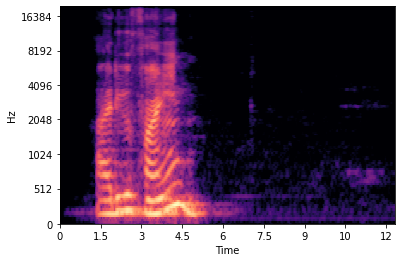

In [ ]:
y, sr = librosa.load("/content/recording1.wav")

yt,_=librosa.effects.trim(y)

  # Converting the sound clips into a melspectogram with librosa
  # A mel spectrogram is a spectrogram where the frequencies are converted to the mel scale
audio_spectogram = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=1024, hop_length=100)

  # Convert a power spectrogram (amplitude squared) to decibel (dB) units with power_to_db
audio_spectogram = librosa.power_to_db(audio_spectogram, ref=np.max)

  # Display the spectrogram with specshow
librosa.display.specshow(audio_spectogram, y_axis='mel', fmax=20000, x_axis='time')

p = os.path.join('/content/drive/MyDrive/Prml_project/Live_images', "{}.jpg".format(1))
plt.savefig(p)
is_angry,a, probs = model.predict(p)
print("How is your mood?", is_angry,'\n')

In [ ]:
def find(audio_file):
  y, sr = librosa.load(audio_file)

  yt,_=librosa.effects.trim(y)

  # Converting the sound clips into a melspectogram with librosa
  # A mel spectrogram is a spectrogram where the frequencies are converted to the mel scale
  audio_spectogram = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=1024, hop_length=100)

  # Convert a power spectrogram (amplitude squared) to decibel (dB) units with power_to_db
  audio_spectogram = librosa.power_to_db(audio_spectogram, ref=np.max)

  # Display the spectrogram with specshow
  librosa.display.specshow(audio_spectogram, y_axis='mel', fmax=20000, x_axis='time')

  p = os.path.join('/content/drive/MyDrive/Prml_project/Live_images', "{}.jpg".format(1))
  plt.savefig(p)
  is_angry,a, probs = model.predict(p)
  print("How is your mood?", is_angry,'\n')



<font color="Blue">Conclusion -</font>
<font size=2px>Classical machine learning models such as KNeighborsClassrifier (KNN), XGBClassifier (XGB), and Random
Forests have distinct advantages to deep neural networks in many tasks but do not match the performance of
even the simplest deep neural network in the task of audio classification. The (MLP) is
the simplest form of DNN suited to classification tasks, provides decent off-the-shelf performance, and can be
precisely tuned to be accurate and relatively quick to train.</font>
Convolutional Neural Networks (CNNs) are DNN candidates for audio data classification: CNNs features engineered on audio data such as spectrograms
have marked resemblance to images, in which CNNs excel at recognizing and discriminating
between distinct patterns.